In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.models as net
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os
import sys

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "D:\lyftauto\dataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./project_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 10, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 0}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 0}, 'test_data_loader': {'key': 'scenes/test.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 0}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_epochs': 1, 'max_num_steps': 100, 'eval_every_n_steps': 10000}, 'val_par

In [3]:
def build_model(modeltype, cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = None
    output_features = 0
    if modeltype == 0:
        model = net.resnet18(pretrained=True)
        output_features = 512
    elif modeltype == 1:
        model = net.resnet50(pretrained=True)
        output_features = 2048
    #elif modeltype == 2:
    #    model = net.alexnet(pretrained=True)
    #    output_features = 4096
    #elif modeltype == 3:
    #    model = net.vgg16(pretrained=True)
    #    output_features = 4096
    
    assert(model != None)
    assert(output_features != 0)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    
    model.fc = nn.Linear(in_features=output_features, out_features=num_targets)

    return model

In [4]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [5]:
train_cfg = cfg["train_data_loader"]

In [6]:

rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss(reduction="none")
cuda_status = torch.cuda.is_available()

In [8]:
model = build_model(1,cfg)
if cuda_status:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train()
torch.set_grad_enabled(True)
    
losslist = []

progress_bar = tqdm(range(cfg["train_params"]["max_num_epochs"]))

for _ in progress_bar:
    training_loss = 0
    for i, data in enumerate(train_dataloader):
        loss, _ = forward(data, model, device, criterion)
        training_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            #progress_bar.set_description(f"loss: {loss.item()}")
        sys.stdout.write("\r" + str(i) + ": " + str(loss.item()))
        sys.stdout.flush()
        if i > cfg["train_params"]["max_num_steps"]:
            break

    training_loss /= i
    losslist.append(training_loss.item())
    progress_bar.set_description(f"loss: {training_loss.item()}")
print(" loss: " + str(sum(losslist)/len(losslist)))

  0%|          | 0/1 [00:00<?, ?it/s]

101: 32.278343200683594

loss: 33.571144104003906: 100%|██████████| 1/1 [01:16<00:00, 76.61s/it]

 loss: 33.571144104003906


In [9]:
#num_frames_to_chop = 100
#eval_cfg = cfg["val_data_loader"]
#eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
#                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

In [10]:
#eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
#eval_mask_path = str(Path(eval_base_path) / "mask.npz")
#eval_gt_path = str(Path(eval_base_path) / "gt.csv")

#eval_zarr = ChunkedDataset(eval_zarr_path).open()
#eval_mask = np.load(eval_mask_path)["arr_0"]
#eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
#eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
#                             num_workers=eval_cfg["num_workers"])
#print(eval_dataset)

In [11]:
val_cfg = cfg["val_data_loader"]
val_zarr = ChunkedDataset(dm.require(val_cfg["key"])).open()
val_dataset = AgentDataset(cfg, val_zarr, rasterizer)
val_dataloader = DataLoader(val_dataset, shuffle=val_cfg["shuffle"], batch_size=val_cfg["batch_size"], 
                             num_workers=val_cfg["num_workers"])
print(val_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [12]:

model.eval()
torch.set_grad_enabled(False)
if cuda_status:
    model = model.cuda()

val_loss = 0
for i, data in enumerate(train_dataloader):
    loss, _ = forward(data, model, device, criterion)
    val_loss += loss.item()
    if i > cfg["val_params"]["max_num_steps"]:
        break
    
print(" err: " + str(val_loss))

    

 err: 40767.98189417273


In [13]:
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

copying: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]
E:\app\anaconda\lib\site-packages\l5kit\evaluation\extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:05<00:00, 92.20it/s] 


In [14]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


E:\app\anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


In [15]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []
    
    for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
        coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


(0, 255, 255)


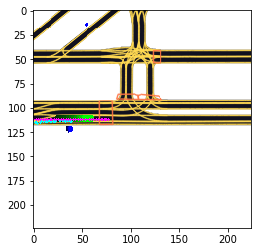

(0, 255, 255)


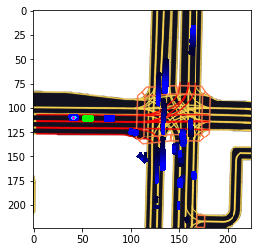

(0, 255, 255)


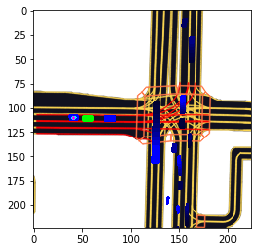

(0, 255, 255)


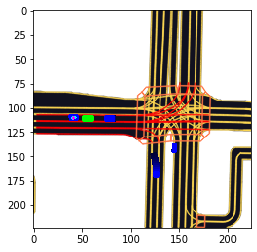

(0, 255, 255)


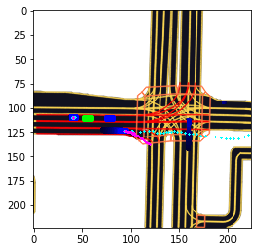

(0, 255, 255)


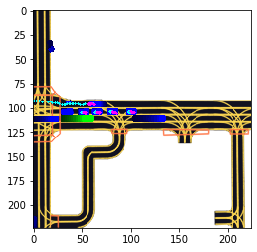

(0, 255, 255)


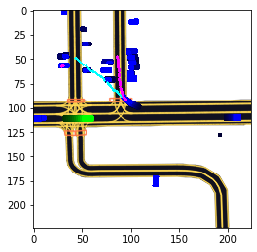

(0, 255, 255)


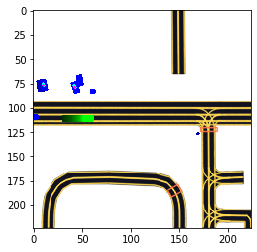

(0, 255, 255)


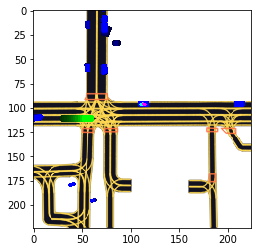

(0, 255, 255)


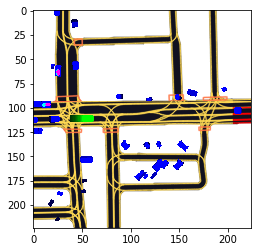

(0, 255, 255)


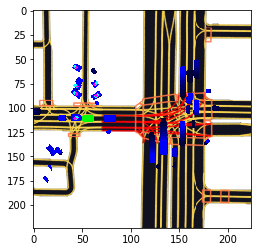

(0, 255, 255)


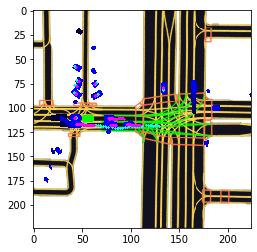

(0, 255, 255)


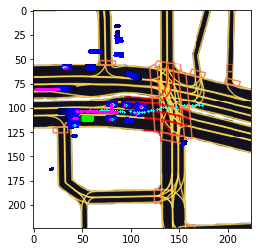

(0, 255, 255)


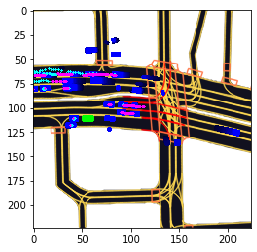

(0, 255, 255)


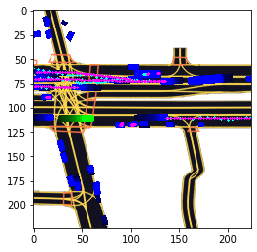

(0, 255, 255)


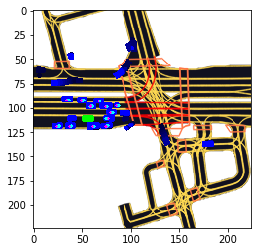

(0, 255, 255)


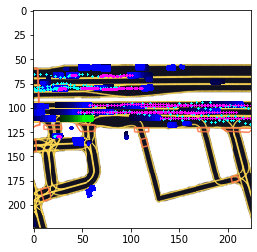

(0, 255, 255)


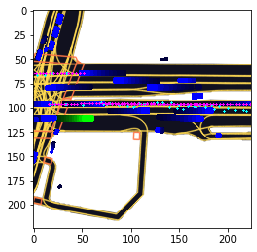

(0, 255, 255)


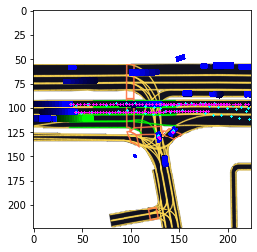

(0, 255, 255)


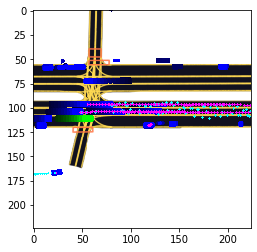

(0, 255, 255)


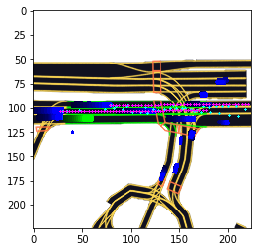

(0, 255, 255)


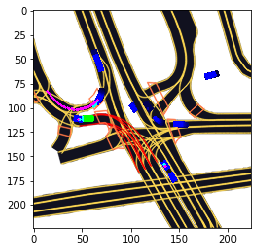

(0, 255, 255)


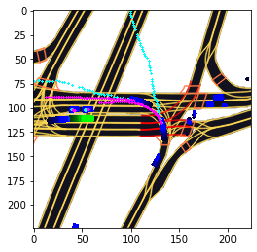

(0, 255, 255)


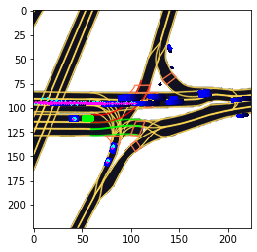

(0, 255, 255)


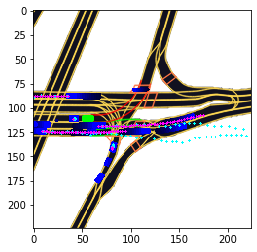

(0, 255, 255)


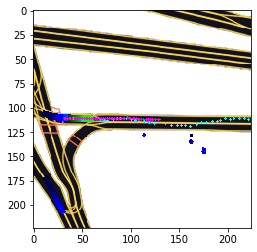

(0, 255, 255)


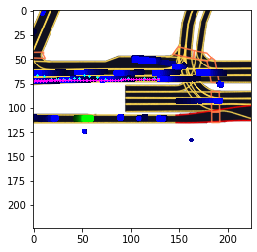

(0, 255, 255)


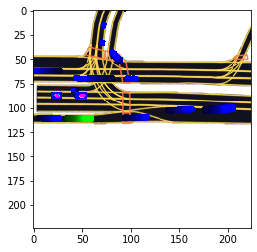

(0, 255, 255)


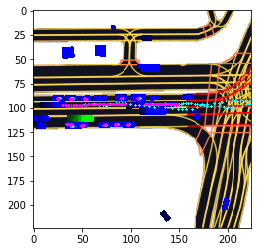

(0, 255, 255)


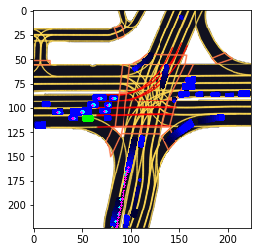

(0, 255, 255)


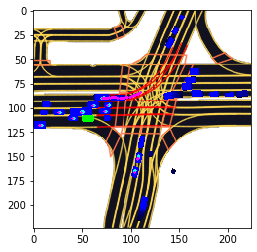

(0, 255, 255)


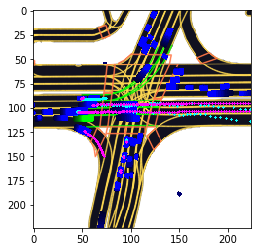

(0, 255, 255)


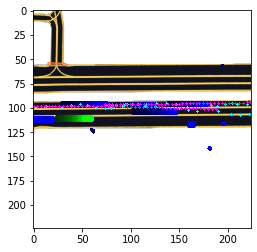

(0, 255, 255)


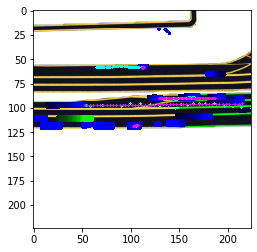

(0, 255, 255)


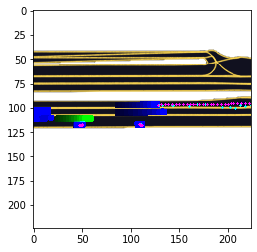

(0, 255, 255)


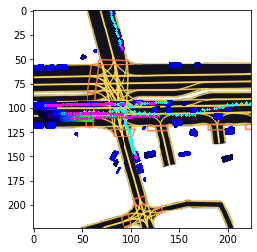

(0, 255, 255)


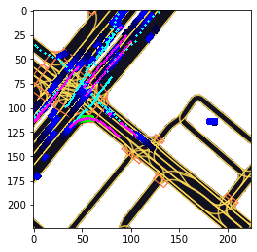

(0, 255, 255)


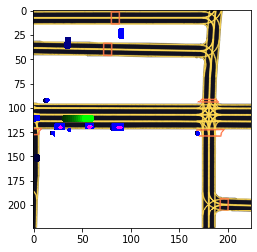

(0, 255, 255)


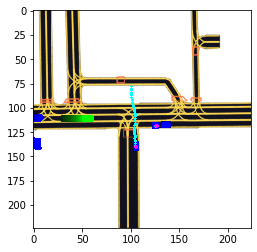

(0, 255, 255)


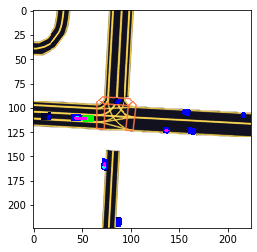

(0, 255, 255)


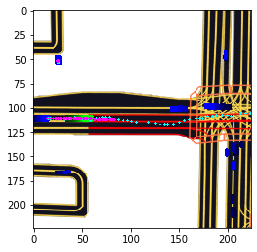

(0, 255, 255)


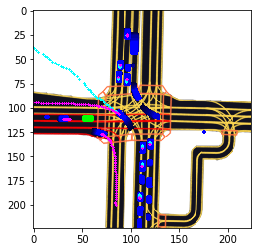

(0, 255, 255)


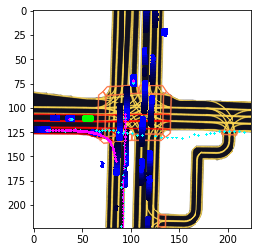

(0, 255, 255)


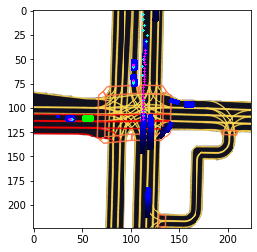

(0, 255, 255)


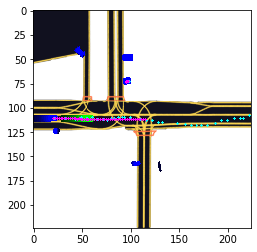

(0, 255, 255)


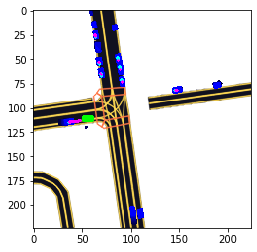

(0, 255, 255)


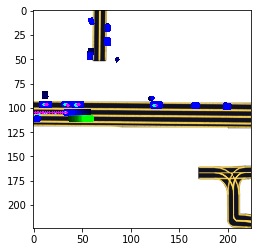

(0, 255, 255)


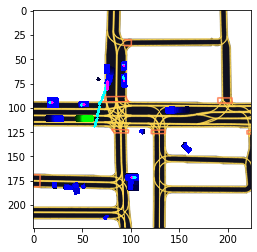

(0, 255, 255)


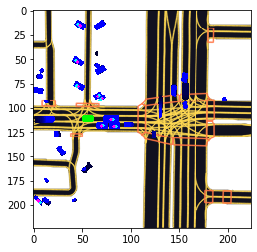

(0, 255, 255)


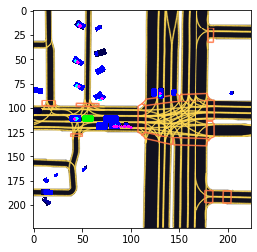

(0, 255, 255)


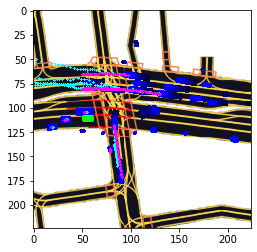

(0, 255, 255)


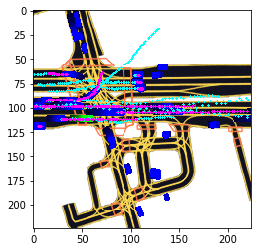

(0, 255, 255)


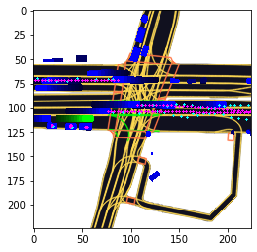

(0, 255, 255)


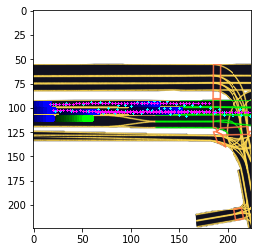

(0, 255, 255)


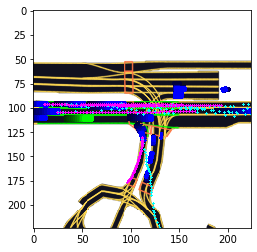

(0, 255, 255)


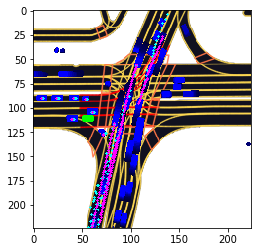

(0, 255, 255)


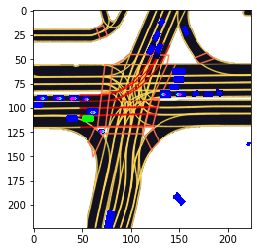

(0, 255, 255)


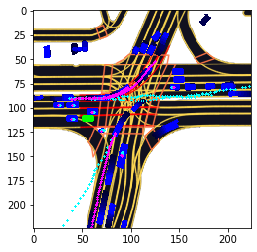

(0, 255, 255)


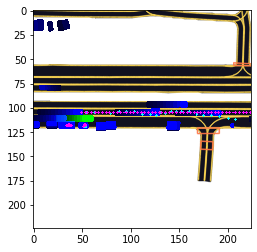

(0, 255, 255)


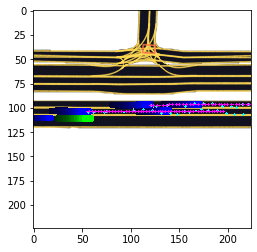

(0, 255, 255)


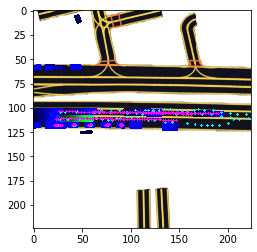

(0, 255, 255)


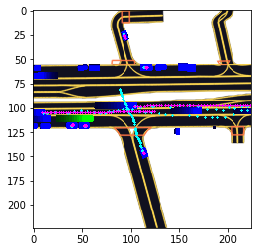

(0, 255, 255)


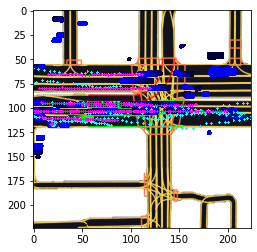

(0, 255, 255)


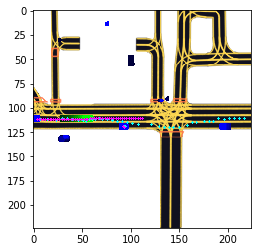

(0, 255, 255)


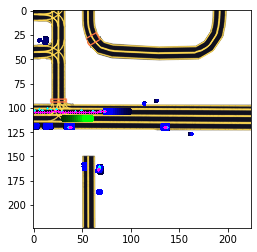

(0, 255, 255)


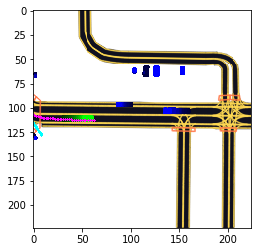

(0, 255, 255)


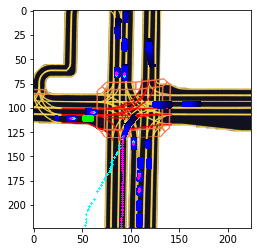

(0, 255, 255)


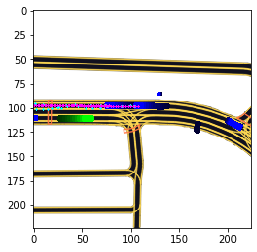

(0, 255, 255)


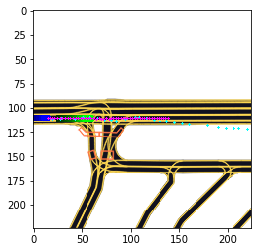

(0, 255, 255)


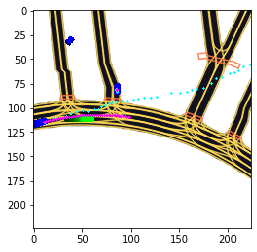

(0, 255, 255)


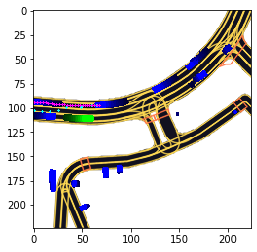

(0, 255, 255)


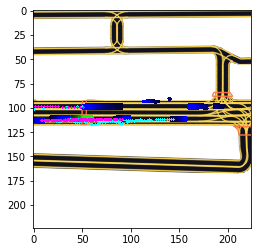

(0, 255, 255)


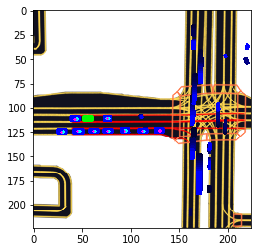

(0, 255, 255)


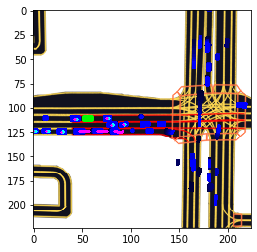

(0, 255, 255)


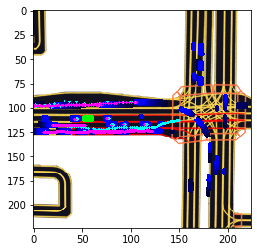

(0, 255, 255)


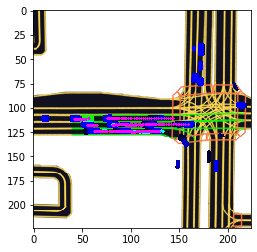

(0, 255, 255)


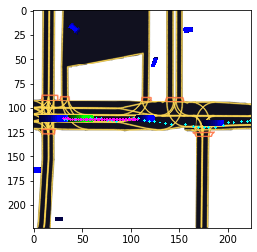

(0, 255, 255)


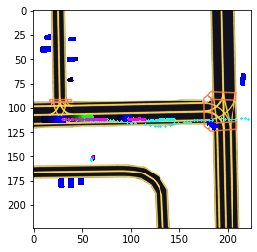

(0, 255, 255)


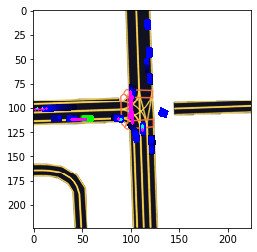

(0, 255, 255)


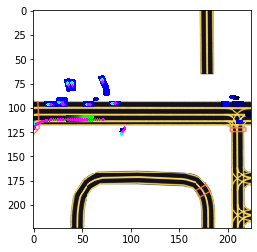

(0, 255, 255)


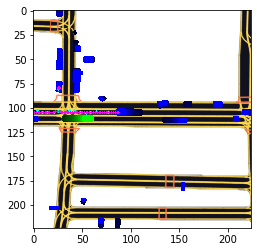

(0, 255, 255)


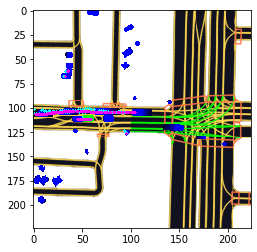

(0, 255, 255)


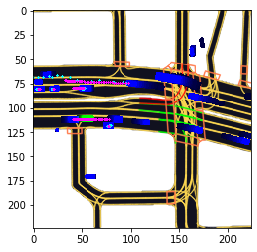

(0, 255, 255)


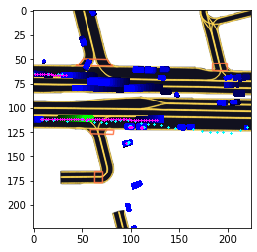

(0, 255, 255)


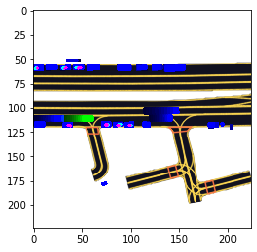

In [16]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    print(PREDICTED_POINTS_COLOR)
    plt.imshow(im_ego[::-1])
    plt.show()